In [1]:
import json

def parse_geojson(geojson):
    X_list, Y_list = [], []
    with open(geojson) as geojson_file:
        geodata = json.load(geojson_file)
        for coords in geodata['features'][0]['geometry']['coordinates'][0]:
            X_list.append(coords[0])
            Y_list.append(coords[1])
    return [min(X_list), min(Y_list), max(X_list), max(Y_list)]

In [2]:
from osgeo import gdal

def download_subarea(geojson, scene_url, out_path):
    scene_url = '/vsicurl/' + scene_url
    gdal.Warp(out_path, scene_url, dstSRS = 'EPSG:4326', cutlineDSName = geojson, cropToCutline = True)

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def display_subarea(subarea_path):
    img = mpimg.imread(subarea_path)
    plt.imshow(img)

In [4]:
import os

IN_DIR = '../../data/query-ts/input/'
OUT_DIR = '../../data/query-ts/output/'
IN_GEOJSON = os.path.join(IN_DIR, 'subarea.geojson')
DATETIME = '2018-09-01/2019-09-28'
MAX_CLOUD_COVER = 5

In [5]:
from satsearch import Search

search = Search.search(bbox=parse_geojson(IN_GEOJSON), datetime=DATETIME, collection='landsat-8-l1', 
                       property=['eo:cloud_cover<'+str(MAX_CLOUD_COVER)]
)
scenes = search.items()

In [6]:
blu_urls, grn_urls, red_urls, nir_urls = [], [], [], []

for i in range(len(scenes)):
    blu_urls.append(scenes[i].assets['B2']['href'])
    grn_urls.append(scenes[i].assets['B3']['href'])
    red_urls.append(scenes[i].assets['B4']['href'])
    nir_urls.append(scenes[i].assets['B5']['href'])

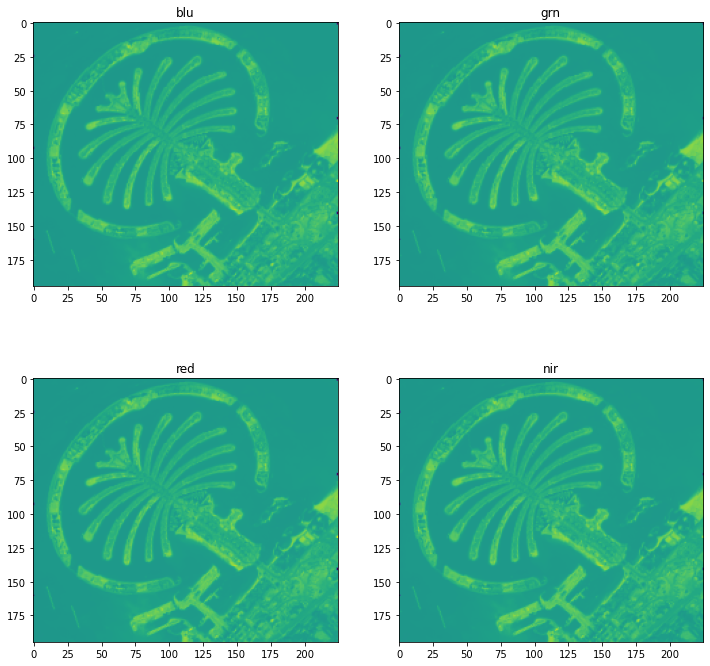

In [7]:
bands = 'blu', 'grn', 'red', 'nir'
out_paths = [os.path.join(OUT_DIR,band+'.tif') for band in bands]

for i in range(0,4):
    download_subarea(IN_GEOJSON, blu_urls[0], out_paths[i])

img_list = [mpimg.imread(band_path) for band_path in out_paths]

fig = plt.figure(figsize=(12,12))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(bands[i])
    ax.imshow(img_list[i])